In [1]:
from datetime import datetime
import traceback
import functools
import multiprocessing
from multiprocessing import Pool

import time
import os
import sys
from pathlib import Path

import numpy as np
import scipy
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy import stats

import pandas as pd

import astropy.units as u
from astropy.io import fits
from astropy.coordinates import Angle
from mmtwfs.wfs import WFSFactory

In [2]:
# instantiate all of the WFS systems...
wfs_keys = ['f9', 'newf9', 'f5', 'mmirs', 'binospec']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name
plt.close('all')

# give mmirs a default
wfs_systems['mmirs'].default_mode = 'mmirs1'

# map f9 to oldf9
wfs_systems['oldf9'] = wfs_systems['f9']

In [3]:
def hist_compare(df1, df2, column, bins=100, mini=None, maxi=None):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    if mini is None:
        mini = df1[column].min()
    if maxi is None:
        maxi = df1[column].max()
    df1.hist(column=column, bins=bins, range=(mini, maxi), alpha=0.6, ax=ax1)
    df2.hist(column=column, bins=bins, range=(mini, maxi), alpha=0.6, ax=ax2)
    plt.xlabel(column)
    plt.ylabel("N")
    f.show()

In [4]:
def seeing(df, wfs):
    """
    Given a sigma derived from a gaussian fit to a WFS spot, deconvolve the systematic width from the reference image
    and relate the remainder to r_0 and thus a seeing FWHM.
    """
    # the effective wavelength of the WFS imagers is about 600-650 nm. we use 650 nm to maintain consistency
    # with the value used by the old SHWFS system.
    wave = wfs.eff_wave
    wave = wave.to(u.m).value  # r_0 equation expects meters so convert
    owave = 500 * u.nm
    owave = owave.to(u.m).value
    
    mode = wfs.default_mode
    
    # calculate the physical size of each aperture.
    ref = wfs.modes[mode]['reference']
    apsize_pix = np.max((ref.xspacing, ref.yspacing))
    d = wfs.telescope.diameter * apsize_pix / wfs.pup_size
    d = d.to(u.m).value  # r_0 equation expects meters so convert

    # we need to deconvolve the instrumental spot width from the measured one to get the portion of the width that
    # is due to spot motion
    ref_sigma = stats.funcs.gaussian_fwhm_to_sigma * wfs.ref_fwhm
    #ref_sigma = stats.funcs.gaussian_fwhm_to_sigma * 0.0
    sigma = stats.funcs.gaussian_fwhm_to_sigma * df['gauss_fwhm']
    
    corr_sigma = np.sqrt(sigma**2 - ref_sigma**2)
    corr_sigma *= wfs.pix_size.to(u.rad).value  # r_0 equation expects radians so convert

    # this equation relates the motion within a single aperture to the characteristic scale size of the
    # turbulence, r_0.
    r_0 = ( 0.179 * (wave**2) * (d**(-1/3))/corr_sigma**2 )**0.6

    # this equation relates the turbulence scale size to an expected image FWHM at the given wavelength.
    raw_seeing = u.Quantity(u.rad * 0.98 * owave / r_0, u.arcsec)

    # correct seeing to zenith
    seeing = raw_seeing / df['AIRMASS']**0.6

    return raw_seeing, seeing

In [5]:
columns = ['filename', 'obstime', 'wfskey', 'AIRMASS', 'AZ', 'EL', 'ellipticity', 'gauss_rms', 'moffat_rms', 'gauss_fwhm', 'moffat_fwhm', 'gauss_amplitude',
           'moffat_amplitude', 'moffat_alpha', 'moffat_gamma']
rootdir = Path("/Volumes/LaCie 8TB/spot_analysis")
dirs = sorted(list(rootdir.glob("20*")))  # pathlib, where have you been all my life!
dataframes = []
for d in dirs:
    if d.is_dir():
        mean_df = pd.read_csv(d / "spot_reduce_mean.csv")
        wfs_df = pd.read_csv(d / "wfskeys.csv")
        df = pd.merge(mean_df, wfs_df, on='filename')
        dataframes.append(df)
data = pd.concat(dataframes, sort=True)
data['moment_fwhm'] = data['moment_fwhm'] * stats.gaussian_fwhm_to_sigma  # this looks like a photuils bug where sigma is actually fwhm and i applied correction i shouldn't have

In [6]:
g = data.groupby('wfskey')
g.wfskey.describe()

,count,unique,top,freq
wfskey,,,,
binospec,16984,1,binospec,16984
f5,100654,1,f5,100654
mmirs,49706,1,mmirs,49706
newf9,1803,1,newf9,1803
oldf9,54128,1,oldf9,54128


In [7]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
fixed_list = []
for wfskey, group in g:
    wfs = wfs_systems[wfskey]
    group = g.get_group(wfskey)
    #group.apply(seeing, axis=1, args=(wfs,))
    group['raw_seeing'], group['seeing'] = seeing(group, wfs)
    fixed_list.append(group)
fixed = pd.concat(fixed_list)
fixed = fixed[np.isfinite(fixed['seeing'])]
fixed = fixed[fixed['gauss_amplitude'] > 10.]

fixed = fixed[~fixed['filename'].str.contains("Ref")]
fixed = fixed[~fixed['filename'].str.contains("ref")]
fixed = fixed[~fixed['filename'].str.contains("back.fits")]
fixed = fixed[~fixed['filename'].str.contains("tmp.fits")]
fixed = fixed[fixed['seeing'] > 0.25]  # trim out reference or bogus images
fixed = fixed[fixed['seeing'] < 5.]  # spot finding doesn't work for bad seeing where motion fills the aperture

fixed = fixed[fixed['peak'] > 500.]  # use only bright spots
#fixed = fixed[(fixed['EXPTIME'] >= 10.) | (fixed['EXPTIME'] == 0.0)]

# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['obstime'], name='ut'))

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


<IPython.core.display.Javascript object>


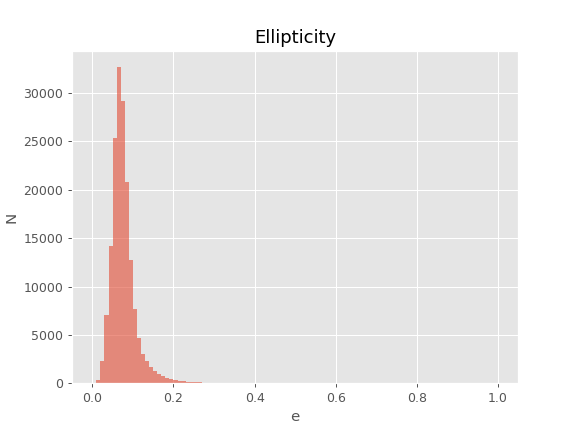

In [8]:
fixed.hist(column='ellipticity', bins=100, range=(0.0, 1.0), alpha=0.6)
plt.title("Ellipticity")
plt.xlabel("e")
plt.ylabel("N")
plt.show()

<IPython.core.display.Javascript object>


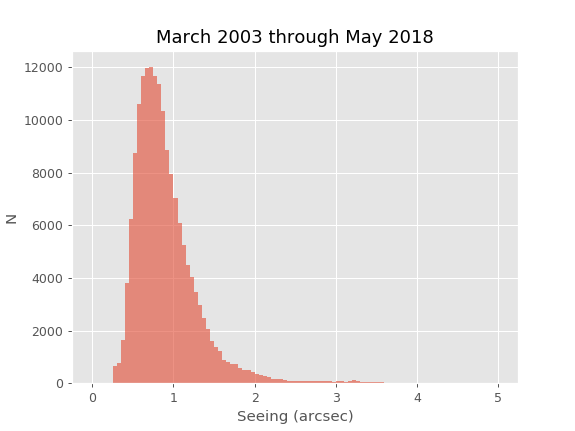

In [9]:
# make raw histogram of the zenith-corrected seeing column
fixed.hist(column='seeing', bins=100, range=(0.0, 5.0), alpha=0.6)
plt.title("March 2003 through May 2018")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [10]:
len(fixed[fixed['wfskey'].str.contains('mmirs')])

18039

In [11]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = scipy.stats.lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = scipy.stats.lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.49297123729174774 0.15277184715741232 0.6746437002065482


<IPython.core.display.Javascript object>


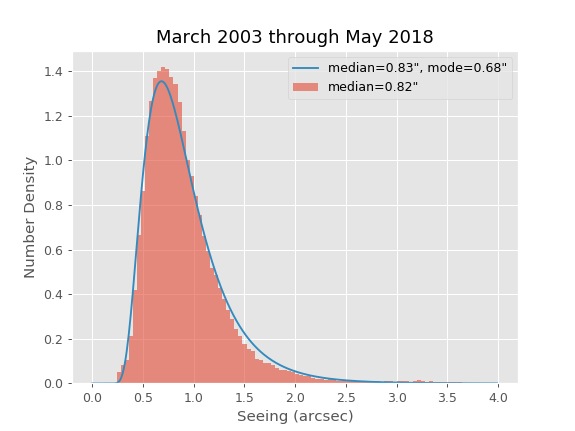

In [12]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Number Density")
plt.title("March 2003 through May 2018")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.savefig("all_seeing.pdf")
plt.show()

In [13]:
yearly_median = []
for i in range(2004, 2018):
    year = str(i)
    med = fixed[year]['seeing'].median()
    print(f"Median seeing for {year} is {med}")
    yearly_median.append(med)

Median seeing for 2004 is 0.8642074113185078
Median seeing for 2005 is 0.8227199734206859
Median seeing for 2006 is 0.8337517028365293
Median seeing for 2007 is 0.8740379930223788
Median seeing for 2008 is 0.8162519247847159
Median seeing for 2009 is 0.7988302163895926
Median seeing for 2010 is 0.8745980730196206
Median seeing for 2011 is 0.8189556917519113
Median seeing for 2012 is 0.7998349388982476
Median seeing for 2013 is 0.817427244785278
Median seeing for 2014 is 0.7801741731032935
Median seeing for 2015 is 0.8102358303371981
Median seeing for 2016 is 0.8122524898078408
Median seeing for 2017 is 0.7812241596525777


<IPython.core.display.Javascript object>


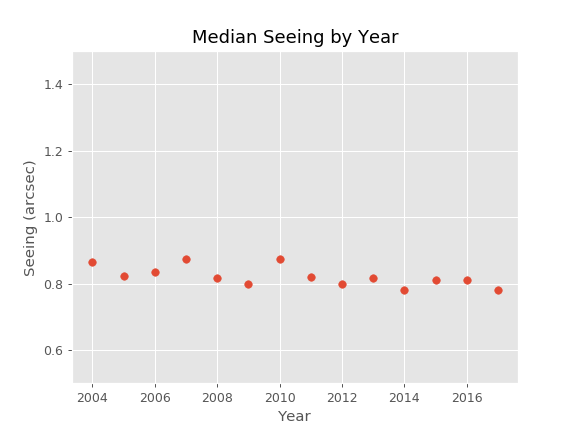

In [14]:
plt.scatter(range(2004, 2018), yearly_median)
plt.title("Median Seeing by Year")
plt.xlabel("Year")
plt.ylabel("Seeing (arcsec)")
plt.ylim(0.5, 1.5)
plt.savefig("yearly_median.pdf")
plt.show()

In [22]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

In [15]:
continuous = fixed[fixed['wfskey'].str.contains('bino') | fixed['wfskey'].str.contains('mmirs')]
f9 = fixed[fixed['wfskey'].str.contains('f9')]
f5 = fixed[fixed['wfskey'].str.contains('f5')]
len(continuous), len(f9), len(f5)

(30997, 46623, 92524)

<IPython.core.display.Javascript object>


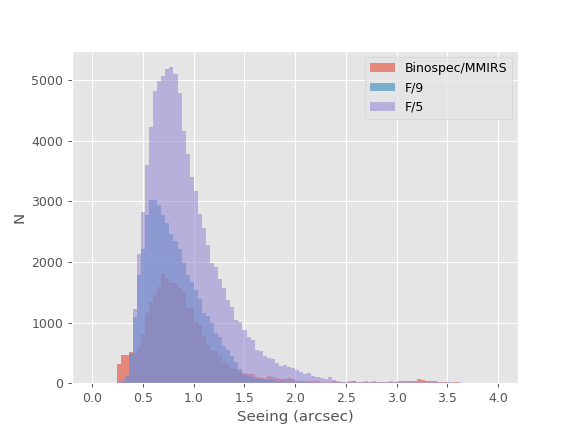

In [17]:
plt.hist(continuous['seeing'], bins=100, range=(0.0, 4.0), label="Binospec/MMIRS", alpha=0.6)
plt.hist(f9['seeing'], bins=100, range=(0.0, 4.0), label="F/9", alpha=0.6)
plt.hist(f5['seeing'], bins=100, range=(0.0, 4.0), label="F/5", alpha=0.6)
plt.legend()
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.savefig("wfs_hists.pdf")
plt.show()

<IPython.core.display.Javascript object>


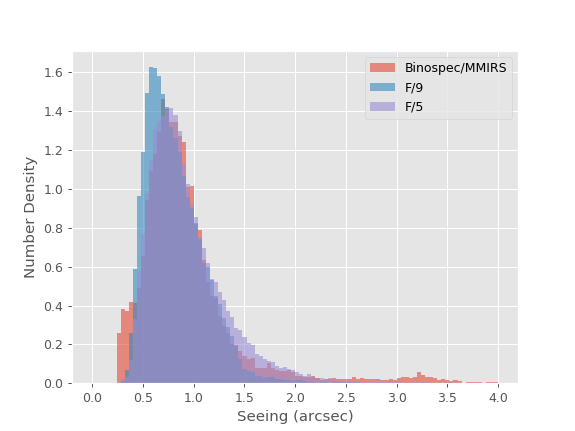

In [18]:
plt.hist(continuous['seeing'], density=True, bins=100, range=(0.0, 4.0), label="Binospec/MMIRS", alpha=0.6)
plt.hist(f9['seeing'], density=True, bins=100, range=(0.0, 4.0), label="F/9", alpha=0.6)
plt.hist(f5['seeing'], density=True, bins=100, range=(0.0, 4.0), label="F/5", alpha=0.6)
plt.legend()
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Number Density")
plt.savefig("wfs_hists_norm.pdf")
plt.show()

In [19]:
np.median(f9['seeing']), np.median(f5['seeing']), np.nanmedian(continuous['seeing'])

(0.7664037872714218, 0.8494632782050195, 0.8248692489423693)

In [20]:
continuous[continuous['seeing'] < 0.3]['filename']

ut
2017-11-11 10:47:05.000                      bino_wfs_1595.fits
2017-11-11 11:56:29.000                      bino_wfs_2065.fits
2017-11-11 12:04:30.000                      bino_wfs_2105.fits
2017-11-11 12:08:20.000                      bino_wfs_2124.fits
2017-11-11 12:12:17.000                      bino_wfs_2142.fits
2017-11-15 02:15:54.000                      bino_wfs_0115.fits
2017-11-15 02:17:27.000                      bino_wfs_0119.fits
2017-11-16 05:34:42.000                      bino_wfs_0606.fits
2017-11-16 05:34:50.000                      bino_wfs_0608.fits
2017-11-16 05:38:55.000                      bino_wfs_0625.fits
2017-11-16 05:39:00.000                      bino_wfs_0626.fits
2017-11-16 05:39:09.000                      bino_wfs_0628.fits
2017-11-16 05:39:35.000                      bino_wfs_0634.fits
2017-11-16 05:40:08.000                      bino_wfs_0640.fits
2017-11-16 05:40:12.000                      bino_wfs_0641.fits
2017-11-16 05:45:06.000              

In [21]:
# plot the results and show that the seeing is better later in the night...
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("half_nights.pdf")
plt.show()

NameError: name 'first_half' is not defined

In [ ]:
months = ["{:02d}".format(m) for m in range(1, 13)]
years = ["{:d}".format(y) for y in range(2003, 2019)]
months, years

In [ ]:
by_month = fixed.groupby([fixed.index.month]).median()

In [ ]:
by_month['seeing']

In [ ]:
month_sizes = [len(g[1]) for g in fixed.groupby([fixed.index.month]).groups.items()]

In [ ]:
mnames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots()
x = range(12)
ax.scatter(x, by_month['seeing'])
ax.set_xticks(x)
ax.set_xticklabels(mnames, rotation=45)
ax.set_ylabel("Median Seeing (arcsec)")
ax.set_ylim(0.5, 1.5)
plt.savefig("monthly_median.pdf")
plt.show()

In [ ]:
fig, ax = plt.subplots()
x = range(12)
plt.bar(x, month_sizes)
ax.set_xticks(x)
ax.set_xticklabels(mnames, rotation=45)
ax.set_ylabel("Samples per Month")
plt.savefig("monthly_samples.pdf")
plt.show()

In [ ]:
bino1_dir = Path("/Users/tim/MMT/bino/GDR1")
bino2_dir = Path("/Users/tim/MMT/bino/GDR2")
dfs = []
for c in bino1_dir.glob("*.csv.gz"):
    df = pd.read_csv(c)
    dfs.append(df)
bino1 = pd.concat(dfs)

dfs = []
for c in bino2_dir.glob("*.csv.gz"):
    df = pd.read_csv(c)
    dfs.append(df)
bino2 = pd.concat(dfs)

In [ ]:
bino1['airmass'] = 1.0 / np.cos((90. - bino1['EL']).data*u.deg)
bino2['airmass'] = 1.0 / np.cos((90. - bino2['EL']).data*u.deg)
bino1['seeing'] = bino1['gauss_fwhm'] / bino1['airmass']**0.6
bino2['seeing'] = bino2['gauss_fwhm'] / bino2['airmass']**0.6
bino1['mseeing'] = bino1['moffat_fwhm'] / bino1['airmass']**0.6
bino2['mseeing'] = bino2['moffat_fwhm'] / bino2['airmass']**0.6

In [ ]:
#fixed = fixed.set_index(pd.DatetimeIndex(fixed['obstime'], name='ut'))
bino1_t = bino1.set_index(pd.DatetimeIndex(bino1['DATE-OBS'], name='ut'))
bino2_t = bino2.set_index(pd.DatetimeIndex(bino2['DATE-OBS'], name='ut'))

In [ ]:
plt.hist(bino1_t['seeing'], bins=100, range=(0.0, 4.0), label="Gaussian", alpha=0.6)
plt.hist(bino1_t['mseeing'], bins=100, range=(0.0, 4.0), label="Moffat", alpha=0.6)
plt.legend(["Gaussian: %.2f\"" % np.nanmedian(bino1_t['seeing']), "Moffat: %.2f\"" % np.nanmedian(bino1_t['mseeing'])])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("gauss_v_moffat.pdf")
plt.show()

In [ ]:
plt.hist(bino1_t['mseeing'], bins=100, range=(0.0, 4.0), label="Camera #1", alpha=0.6)
plt.hist(bino2_t['mseeing'], bins=100, range=(0.0, 4.0), label="Camera #2", alpha=0.6)
plt.legend(["Camera #1: %.2f\"" % np.nanmedian(bino1_t['mseeing']), "Camera #2: %.2f\"" % np.nanmedian(bino2_t['mseeing'])])
#plt.legend()
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("gdr1_v_gdr2.pdf")
plt.show()

In [ ]:
bino_wfs = fixed[fixed['wfskey'].str.contains('binospec')]
bino2018 = bino_wfs['2018']

In [ ]:
plt.hist(bino2018['seeing'], bins=100, range=(0.0, 4.0), density=True, label="WFS", alpha=0.6)
plt.hist(bino2_t['seeing'], bins=100, range=(0.0, 4.0), density=True, label="Guider", alpha=0.6)
plt.legend(["WFS: %.2f\"" % np.nanmedian(bino2018['seeing']), "Guider: %.2f\"" % np.nanmedian(bino2_t['seeing'])])
#plt.legend()
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Number Density")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("wfs_v_gdr.pdf")
plt.show()

In [ ]:
bino2018['EXPTIME'].mean(), bino2_t['EXPTIME'].mean()

In [ ]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each month.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('M').median()
daily['max'] = fixed.seeing.resample('M').max()
daily['min'] = fixed.seeing.resample('M').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
#plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
plt.scatter(daily.index, daily['seeing'])
labels = ax.get_xticklabels()
plt.setp(labels, rotation=20, fontsize=8, ha='right')
plt.ylabel("Seeing (arcsec)")
plt.title("Median Seeing by Month")
plt.savefig("monthly_median.pdf")
plt.show()

In [ ]:
hourly_medians = []
times = []
hourly_sizes = []
for h in range(1, 13):
    stime = "{:02d}:00".format(h)
    mtime = "{:02d}:30".format(h)
    etime = "{:02d}:00".format(h+1)
    tslice = fixed.between_time(start_time=stime, end_time=etime)
    med = np.median(tslice['seeing'])
    hourly_medians.append(med)
    hourly_sizes.append(len(tslice))
    times.append(mtime)

In [ ]:
hourly_medians, hourly_sizes

In [ ]:
fig, ax = plt.subplots()
x = range(12)
ax.scatter(x, hourly_medians)
ax.set_xticks(x)
ax.set_xticklabels(times, rotation=45)
ax.set_ylabel("Median Seeing (arcsec)")
ax.set_title("Median Seeing vs. UT")
plt.savefig("hourly_median.pdf")
plt.show()

In [ ]:
fig, ax = plt.subplots()
x = range(12)
plt.bar(x, hourly_sizes)
ax.set_xticks(x)
ax.set_xticklabels(times, rotation=45)
ax.set_ylabel("Samples per Hour")
plt.savefig("hourly_samples.pdf")
plt.show()

In [ ]:
len(data), len(fixed)

In [ ]:
for c in fixed.columns:
    if 'wdir' in c.lower():
        print(c)
    if 'wind' in c.lower():
        print(c)

In [ ]:
fixed['wind_speed'] = fixed['WIND']
fixed['wind_speed'] = fixed['wind_speed'].fillna(fixed['WIND_W'])
fixed['wind_dir'] = fixed['WINDDIR']
fixed['wind_dir'] = fixed['wind_dir'].fillna(fixed['WDIR_W'])
wfixed = fixed[fixed['wind_speed'] > 0.0]

In [ ]:
wfixed['wind_dir'].median()

In [ ]:
wfixed.hist(column='wind_speed', bins=50, range=(0.0, 50.0), alpha=0.6)
plt.title("")
plt.xlabel("Wind Speed (mph)")
plt.ylabel("N")
plt.savefig("wind_hist.pdf")
plt.show()

In [ ]:
wfixed.hist(column='wind_dir', bins=180, range=(0.0, 360.0), alpha=0.6)
plt.title("")
plt.xlabel("Wind Direction (deg)")
plt.ylabel("N")
plt.savefig("winddir_hist.pdf")
plt.show()

In [ ]:
winds = np.arange(2, 42, 4)
list(winds)

In [ ]:
wmeds = []
for w in winds:
    wl = w - 2
    wu = w + 2
    dslice = wfixed[(wfixed['wind_speed'] >= wl) & (wfixed['wind_speed'] < wu)]
    med = dslice['seeing'].median()
    wmeds.append(med)
wmeds

In [ ]:
fig, ax = plt.subplots()
ax.scatter(winds, wmeds)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(winds)
ax.set_ylabel("Median Seeing (arcsec)")
ax.set_xlabel("Wind Speed (mph)")
plt.savefig("seeing_v_wind.pdf")
plt.show()

In [ ]:
az = np.arange(22.5, 360, 22.5)
az
aznames = ['NNE', 'NE', "ENE", 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

In [ ]:
ameds = []
for a in az:
    al = a - 22.5
    au = a + 22.5
    dslice = wfixed[(wfixed['wind_dir'] >= al) & (wfixed['wind_dir'] < au)]
    med = dslice['seeing'].median()
    ameds.append(med)
ameds

In [ ]:
fig, ax = plt.subplots()
ax.scatter(az, ameds)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(az)
ax.set_xticklabels(aznames, rotation=45, size='x-small')
ax.set_ylabel("Median Seeing (arcsec)")
ax.set_xlabel("Wind Direction")
ax.xaxis.set_label_position('top')
plt.savefig("seeing_v_winddir.pdf")
plt.show()

In [ ]:
tel_wind_offset = wfixed['AZ'] - wfixed['wind_dir']
tel_wind_angle = Angle(tel_wind_offset.data * u.deg)
tel_wind_angle.wrap_at('180d', inplace=True)
wfixed['tel_wind_angle'] = np.abs(tel_wind_angle)

In [ ]:
wfixed['tel_wind_angle'].median()

In [ ]:
angles = range(10, 180, 10)
tameds = []
for a in angles:
    al = a - 10
    au = a + 10
    dslice = wfixed[(wfixed['tel_wind_angle'] >= al) & (wfixed['tel_wind_angle'] < au)]
    med = dslice['seeing'].median()
    tameds.append(med)
tameds

In [ ]:
fig, ax = plt.subplots()
ax.scatter(angles, tameds)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(angles)
ax.set_ylabel("Median Seeing (arcsec)")
ax.set_xlabel("Azimuth/Wind Direction Offset (deg)")
ax.xaxis.set_label_position('top')
ax.set_xticklabels(angles, rotation=45, size='small')
plt.savefig("seeing_v_telaz.pdf")
plt.show()

In [ ]:
short = fixed[fixed['EXPTIME'] <= 5.0]
medium = fixed[(fixed['EXPTIME'] > 5.0) & (fixed['EXPTIME'] < 20.0)]
long = fixed[fixed['EXPTIME'] >= 20.0]

fixed.hist(column='EXPTIME', bins=100, range=(0, 60), alpha=0.6)
plt.title("WFS Exposure Times")
plt.ylabel("N")
plt.xlabel("Exposure Time (sec)")
plt.text(60, 31500, "<= 5 sec -> {:0.2f}\"".format(short['seeing'].median()), horizontalalignment='right')
plt.text(60, 28500, "5-20 sec -> {:0.2f}\"".format(medium['seeing'].median()), horizontalalignment='right')
plt.text(60, 25500, ">= 20 sec -> {:0.2f}\"".format(long['seeing'].median()), horizontalalignment='right')
plt.savefig("exptime_v_seeing.pdf")
plt.show()

In [ ]:
short = fixed[fixed['EXPTIME'] <= 5.0]
medium = fixed[(fixed['EXPTIME'] > 5.0) & (fixed['EXPTIME'] < 20.0)]
long = fixed[fixed['EXPTIME'] >= 20.0]
short['seeing'].median(), medium['seeing'].median(), long['seeing'].median()

In [ ]:
for c in fixed.columns:
    if 'exp' in c.lower():
        print(c)

In [ ]:
expfixed = fixed[fixed['EXPTIME'] <= 7.]

# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = scipy.stats.lognorm.fit(expfixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = scipy.stats.lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(expfixed['seeing'])
fit_median = exp_mu + loc

In [ ]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
plt.hist(expfixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Number Density")
plt.title("Exposure Time < 7 sec")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.savefig("short_exp_seeing.pdf")
plt.show()

In [ ]:
pixsize = wfs_systems['binospec'].pix_size.value
reffwhm = wfs_systems['binospec'].modes['binospec']['reference'].fwhm
simple = np.sqrt(bino2018['gauss_fwhm']**2 - reffwhm**2)

In [ ]:
plt.hist(simple*pixsize, density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
plt.hist(bino2018['seeing'], bins=100, range=(0.0, 4.0), density=True, label="WFS", alpha=0.6)
plt.show()

In [ ]:
plt.hist(bino2018['moment_fwhm']*gaussian_fwhm_to_sigma, bins=100, range=(0.0, 30.0),  alpha=0.6)
plt.hist(bino2018['gauss_fwhm'], bins=100, range=(0.0, 10.0),  alpha=0.6)
plt.hist(bino2018['semiminor_axis_sigma'], bins=100, range=(0.0, 10.0), alpha=0.6)
plt.show()

In [24]:
fixed['raw_seeing'].min()

0.25267510042316016

In [77]:
airmasses = []
data = []
for s in np.linspace(1.1, 2.1, 11):
    sl = s - 0.1
    secz = 0.5*(s + sl)
    airmasses.append(secz)
    secz_slice = fixed[(fixed['AIRMASS'] >= sl) & (fixed['AIRMASS'] < s)]
    print(len(secz_slice))
    data.append(secz_slice['raw_seeing'])

53818
37408
29669
16989
10468
8038
4224
4084
2488
2053
1071


In [71]:
pred = 0.82 * np.array(airmasses)**0.6

In [72]:
pred

array([0.84435957, 0.89172831, 0.93747536, 0.98177985, 1.02478947,
       1.06662773, 1.10739923, 1.14719351, 1.18608794, 1.22414995,
       1.26143875])

In [73]:
fixed['raw_seeing'].std()

0.5239348295704138

<IPython.core.display.Javascript object>


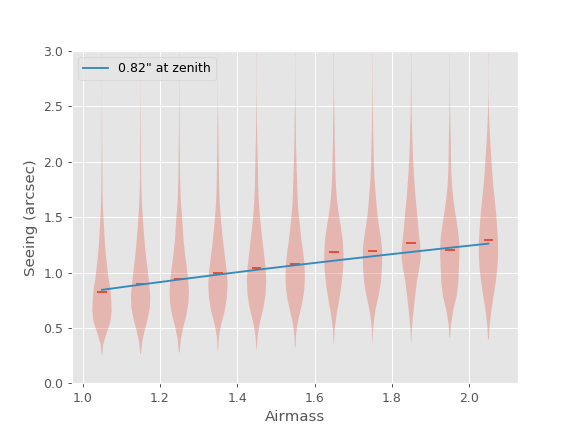

In [76]:
plt.violinplot(data, airmasses, points=50, widths=0.05, showextrema=False, showmedians=True)
plt.plot(airmasses, pred, label="0.82\" at zenith")
plt.legend(loc=2)
plt.ylim(0.0, 3.0)
plt.xlabel("Airmass")
plt.ylabel("Seeing (arcsec)")
plt.savefig("airmass_corr.png")
plt.show()

In [57]:
len(fixed)

170144

In [78]:
plt.violinplot?